In [4]:
# Import Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

In [5]:
# Import Production Data (and State Index)
# Production Data Source
# https://www.kaggle.com/datasets/kevinmorgado/us-energy-generation-2001-2022?select=organised_Gen.csv

# Load the State Index CSV file
state_df = pd.read_csv("Resources/states.csv", usecols = ['State', 'Code'])

# Load the Production CSV file and exclude first column
col_list = ['YEAR', 'MONTH', 'STATE', 'TYPE OF PRODUCER', 'ENERGY SOURCE', 'GENERATION (Megawatthours)']
prod_df = pd.read_csv("Resources/organised_Gen.csv", usecols = col_list)

# Assign title case to column names and rename 'State'
col_list_cased = [col.title() for col in col_list]
prod_df.columns = col_list_cased

# Filter for years 2002 - 2021 to match investment data set
prod_df = prod_df.loc[(prod_df['Year'] > 2001) & (prod_df['Year'] < 2022) & (prod_df['State'] != 'US-TOTAL') & (prod_df['Type Of Producer'] == "Total Electric Power Industry")]

# Filter for common energy types across both data sets
prod_source_list = ['Geothermal', 'Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic', 'Wind']
prod_df = prod_df.loc[prod_df['Energy Source'].isin(prod_source_list)]

# Rename energy sources to common convention
prod_df = prod_df.replace(['Hydroelectric Conventional', 'Other Biomass', 'Solar Thermal and Photovoltaic'], 
                          ['Hydroelectric', 'Biomass', 'Solar'])

# Display sample data
prod_df.head(20)

Year  Month State               Type Of Producer  Energy Source  \
20215  2002      1    AK  Total Electric Power Industry  Hydroelectric   
20217  2002      1    AK  Total Electric Power Industry        Biomass   
20242  2002      1    AL  Total Electric Power Industry  Hydroelectric   
20244  2002      1    AL  Total Electric Power Industry        Biomass   
20273  2002      1    AR  Total Electric Power Industry  Hydroelectric   
20275  2002      1    AR  Total Electric Power Industry        Biomass   
20302  2002      1    AZ  Total Electric Power Industry  Hydroelectric   
20303  2002      1    AZ  Total Electric Power Industry          Solar   
20304  2002      1    AZ  Total Electric Power Industry        Biomass   
20336  2002      1    CA  Total Electric Power Industry  Hydroelectric   
20337  2002      1    CA  Total Electric Power Industry           Wind   
20338  2002      1    CA  Total Electric Power Industry          Solar   
20340  2002      1    CA  Total Electric Power Industry     Geothermal   
20341  2002      1    CA  Total Electric Power Industry        Biomass   
20392  2002      1    CO  Total Electric Power Industry  Hydroelectric   
20393  2002      1    CO  Total Electric Power Industry           Wind   
20394  2002      1    CO  Total Electric Power Industry        Biomass   
20427  2002      1    CT  Total Electric Power Industry  Hydroelectric   
20428  2002      1    CT  Total Electric Power Industry        Biomass   
20481  2002      1    FL  Total Electric Power Industry  Hydroelectric   

       Generation (Megawatthours)  
20215                    118944.0  
20217                       999.0  
20242                    947959.0  
20244                      1622.0  
20273                    230870.0  
20275                       288.0  
20302                    687079.0  
20303                        37.0  
20304                      6063.0  
20336                   2515525.0  
20337                    131448.0  
20338                     11283.0  
20340                   1147970.0  
20341                    157510.0  
20392                    105925.0  
20393                     16080.0  
20394                      2528.0  
20427                     31623.0  
20428                     66637.0  
20481                     13119.0

In [6]:
# Import Investment Data
# Investment Data Source:
# https://www.wctsservices.usda.gov/Energy/Downloads

# Load the Investment Excel file, "Detailed" Sheet
inv_df = pd.read_excel("Resources/EnergyInvestments_DataDownloads.xlsx", sheet_name = "Detailed")

# Unused state list
state_ex = ['American Samoa', 'Commonwealth of the Northern Mariana Islands', 'Federated States of Micronesia', 'Guam', 'Marshall Islands', 'Puerto Rico', 
            'United States Virgin Islands']

# Filter for years 2002 - 2021 to match investment data set, filter out unused states and 'Total' rows
inv_df = inv_df.loc[~inv_df['State'].isin(state_ex)]

# Filter for common energy types across both data sets
inv_source_list = ['Geothermal', 'Hydroelectric', 'Renewable Biomass', 'Solar', 'Wind']
inv_df = inv_df.loc[inv_df['Energy Type'].isin(inv_source_list)]

# Rename energy sources to common convention
inv_df = inv_df.replace('Renewable Biomass', 'Biomass')

# Join with State Index data to get State Abbreviation column
inv_df = pd.merge(inv_df, state_df, on = "State")

# Rename columns
inv_df.rename(columns={"State": "State Name", "Code": "State", "Energy Type": "Energy Source", "Program_Name": "Program Name"}, inplace = True)

# Display sample data
inv_df.head()

State Name   County Congressional District Zip Code Energy Source Agency  \
0    Alabama  Baldwin                  AL-01    36507       Biomass    FSA   
1    Alabama  Baldwin                  AL-01    36551       Biomass    FSA   
2    Alabama  Baldwin                  AL-01    36567       Biomass    FSA   
3    Alabama  Baldwin                  AL-01    36580       Biomass    FSA   
4    Alabama  Baldwin                  AL-01    36580       Biomass    RBS   

   Year                             Program Name  Total Number of Investments  \
0  2010            BCAP Matching Payments (NOFA)                            2   
1  2010            BCAP Matching Payments (NOFA)                            1   
2  2010            BCAP Matching Payments (NOFA)                            1   
3  2010            BCAP Matching Payments (NOFA)                            1   
4  2021  Rural Energy for America Program (REAP)                            1   

   Total Amount of Assistance   Description State  
0                     40736.0           NaN    AL  
1                     16509.0           NaN    AL  
2                       639.0           NaN    AL  
3                     16334.0           NaN    AL  
4                   7000000.0  Landfill Gas    AL

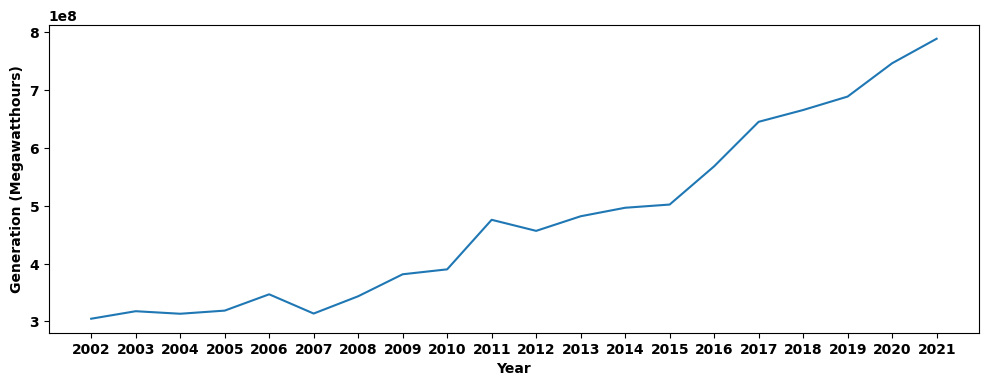

In [4]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 (all states combined)
# Groupby 'Year'
prod_df_year = prod_df.groupby(["Year"])

# x-axis
x_axis = prod_df_year['Year'].first()

# y-axis
y_axis = prod_df_year['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
plt.plot(x_axis, y_axis)
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.show()

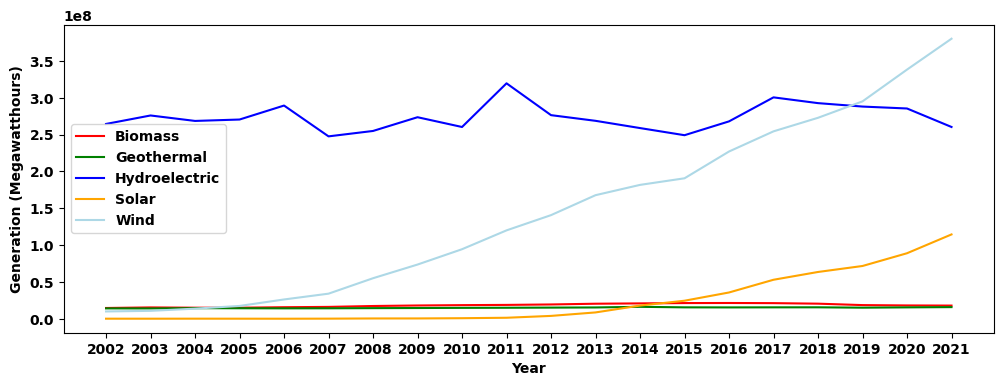

In [5]:

## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)
# Energy Source List
source_list = ['Biomass', 'Geothermal', 'Hydroelectric', 'Solar', 'Wind']

# Color List
colors = ['red', 'green', 'blue', 'orange', 'lightblue']

# y-axis - Filter for 'Energy Source'
prod_df_bio = prod_df.loc[prod_df['Energy Source'] == source_list[0]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo = prod_df.loc[prod_df['Energy Source'] == source_list[1]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd = prod_df.loc[prod_df['Energy Source'] == source_list[2]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol = prod_df.loc[prod_df['Energy Source'] == source_list[3]].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd = prod_df.loc[prod_df['Energy Source'] == source_list[4]].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Line plot
plt.figure(figsize = (12, 4))
bio, = plt.plot(x_axis, prod_df_bio, color = colors[0], label = source_list[0])
geo, = plt.plot(x_axis, prod_df_geo, color = colors[1], label = source_list[1])
hyd, = plt.plot(x_axis, prod_df_hyd, color = colors[2], label = source_list[2])
sol, = plt.plot(x_axis, prod_df_sol, color = colors[3], label = source_list[3])
wnd, = plt.plot(x_axis, prod_df_wnd, color = colors[4], label = source_list[4])
plt.xlabel("Year")
plt.xticks(np.arange(x_axis.min(), x_axis.max() + 1, 1.0))
plt.ylabel("Generation (Megawatthours)")
plt.legend(handles = [bio, geo, hyd, sol, wnd], loc = "best")
plt.show()

In [6]:
## Look at the trend of total production ('Generation (Megawatthours)') from 2002 - 2021 per Energy Source (all states combined)

# Filter for 2002, 2021 and ENergy Source
prod_df_bio_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_02 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2002)].groupby(["Year"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["Year"])['Generation (Megawatthours)'].sum()

# Build summary table showing descending movement per energy source
summary = pd.DataFrame({'Energy Source': source_list,
                       'Movement 2021 vs 2002':[(list(prod_df_bio_21)[0] / list(prod_df_bio_02)[0]) - 1,
                                                (list(prod_df_geo_21)[0] / list(prod_df_geo_02)[0]) - 1,
                                                (list(prod_df_hyd_21)[0] / list(prod_df_hyd_02)[0]) - 1,
                                                (list(prod_df_sol_21)[0] / list(prod_df_sol_02)[0]) - 1,
                                                (list(prod_df_wnd_21)[0] / list(prod_df_wnd_02)[0]) - 1]})
summary = summary.sort_values(by=['Movement 2021 vs 2002'], ascending = False)
summary['Movement 2021 vs 2002'] = summary['Movement 2021 vs 2002'].map("{:,.0%}".format)
summary


Energy Source Movement 2021 vs 2002
3          Solar               20,569%
4           Wind                3,568%
0        Biomass                   22%
1     Geothermal                   12%
2  Hydroelectric                   -2%

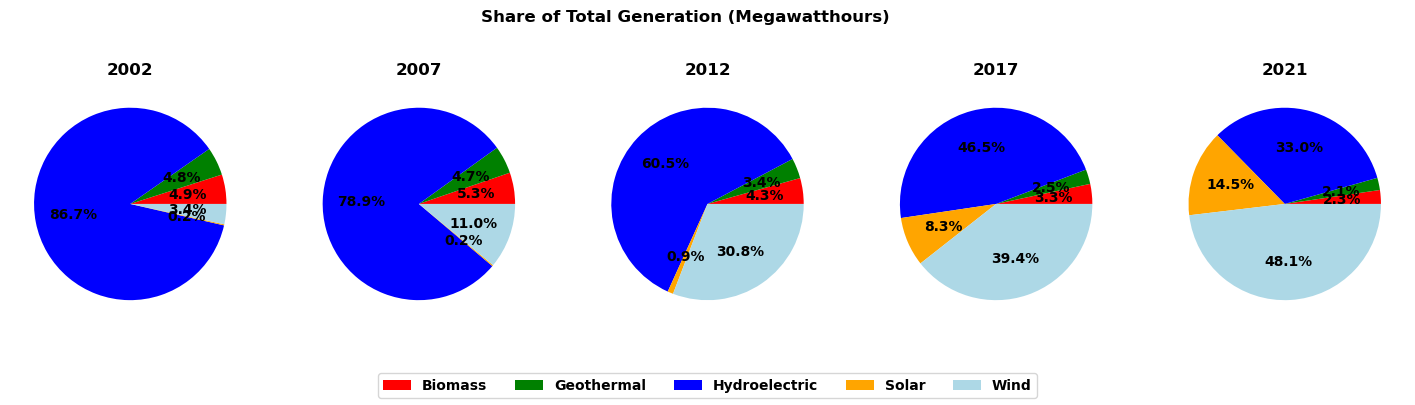

In [7]:
## Look at the trend of share total production ('Generation (Megawatthours)') every five years from 2002 - 2021 per Energy Source (all states combined)

# Filter for every five years - 2002, 2007, 2012, 2017, 2021
prod_df_02 = prod_df.loc[prod_df['Year'] == 2002].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_07 = prod_df.loc[prod_df['Year'] == 2007].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_12 = prod_df.loc[prod_df['Year'] == 2012].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_17 = prod_df.loc[prod_df['Year'] == 2017].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()
prod_df_21 = prod_df.loc[prod_df['Year'] == 2021].groupby(['Energy Source'])['Generation (Megawatthours)'].sum()

# y labels
label_source = prod_df.groupby(['Energy Source'])['Energy Source'].first()

# Build pie chart subplots
fig, axs = plt.subplots(1, 5, figsize=(18, 4), sharey=True)
axs[0].pie(list(prod_df_02), colors = colors, autopct="%1.1f%%")
axs[0].title.set_text('2002')
axs[1].pie(list(prod_df_07), colors = colors, autopct="%1.1f%%")
axs[1].title.set_text('2007')
axs[2].pie(list(prod_df_12), colors = colors, autopct="%1.1f%%")
axs[2].title.set_text('2012')
axs[3].pie(list(prod_df_17), colors = colors, autopct="%1.1f%%")
axs[3].title.set_text('2017')
axs[4].pie(list(prod_df_21), colors = colors, autopct="%1.1f%%")
axs[4].title.set_text('2021')
fig.suptitle('Share of Total Generation (Megawatthours)')
fig.legend(list(label_source), loc='lower center', ncol=len(list(label_source)), bbox_transform=fig.transFigure)


In [8]:
## Look at share of total production ('Generation (Megawatthours)') per Energy Source per State in 2021

# Filter by 2021 and group by State for ALL Energy Sources combined
prod_df_state = prod_df.loc[prod_df['Year'] == 2021].groupby(['State'])['Generation (Megawatthours)'].sum()

# Filter by 2021 and group by State for each Energy Source
prod_df_bio_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[0]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_geo_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[1]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_hyd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[2]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_sol_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[3]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()
prod_df_wnd_21 = prod_df.loc[(prod_df['Energy Source'] == source_list[4]) & (prod_df['Year'] == 2021)].groupby(["State"])['Generation (Megawatthours)'].sum()

# Merge datasets to show evergy sources side-by-side
state_pct = pd.merge(prod_df_state, prod_df_bio_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)_x": "Total", "Generation (Megawatthours)_y": source_list[0]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_geo_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[1]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_hyd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[2]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_sol_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[3]}, inplace = True)
state_pct = pd.merge(state_pct, prod_df_wnd_21, how = 'left', on = "State")
state_pct.rename(columns={"Generation (Megawatthours)": source_list[4]}, inplace = True)
state_pct = state_pct.fillna(0)

# Create new columns for % share of total production
state_pct['Biomass %'] = (state_pct[source_list[0]] / state_pct['Total'])
state_pct['Geothermal %'] = (state_pct[source_list[1]] / state_pct['Total'])
state_pct['Hydroelectric %'] = (state_pct[source_list[2]] / state_pct['Total'])
state_pct['Solar %'] = (state_pct[source_list[3]] / state_pct['Total'])
state_pct['Wind %'] = (state_pct[source_list[4]] / state_pct['Total'])
state_pct = state_pct.iloc[:, 6:11]
state_pct

Biomass %  Geothermal %  Hydroelectric %   Solar %    Wind %
State                                                              
AK      0.021093      0.000000         0.908719  0.000000  0.070188
AL      0.002903      0.000000         0.959141  0.037957  0.000000
AR      0.019072      0.000000         0.886010  0.094918  0.000000
AZ      0.001543      0.000000         0.411838  0.473327  0.113292
CA      0.032963      0.145859         0.185523  0.436547  0.199108
CO      0.004324      0.000000         0.089103  0.094817  0.811755
CT      0.431041      0.000000         0.294164  0.263201  0.011594
DC      0.681995      0.000000         0.000000  0.318005  0.000000
DE      0.517045      0.000000         0.000000  0.447665  0.035291
FL      0.184629      0.000000         0.019409  0.795963  0.000000
GA      0.034769      0.000000         0.447593  0.517639  0.000000
HI      0.163443      0.094403         0.061950  0.295919  0.384285
IA      0.005258      0.000000         0.025168  0.005975  0.963598
ID      0.008974      0.006735         0.717165  0.046818  0.220308
IL      0.020086      0.000000         0.006535  0.026734  0.946645
IN      0.048704      0.000000         0.027676  0.072049  0.851572
KS      0.002484      0.000000         0.001162  0.002396  0.993958
KY      0.020904      0.000000         0.971093  0.008003  0.000000
LA      0.042969      0.000000         0.840866  0.116165  0.000000
MA      0.248971      0.000000         0.218620  0.474413  0.057997
MD      0.101185      0.000000         0.577331  0.180574  0.140910
ME      0.018134      0.000000         0.511703  0.030631  0.439532
MI      0.089590      0.000000         0.142439  0.042553  0.725418
MN      0.022497      0.000000         0.055690  0.119216  0.802597
MO      0.009296      0.000000         0.213716  0.013833  0.763155
MS      0.028414      0.000000         0.000000  0.971586  0.000000
MT      0.000921      0.000000         0.773177  0.002645  0.223257
NC      0.029660      0.000000         0.408970  0.534174  0.027197
ND      0.000079      0.000000         0.132358  0.000000  0.867562
NE      0.008046      0.000000         0.114584  0.005027  0.872343
NH      0.078359      0.000000         0.642041  0.002177  0.277423
NJ      0.316448      0.000000         0.007991  0.666671  0.008889
NM      0.002184      0.004018         0.014757  0.139061  0.839980
NV      0.004713      0.303801         0.150961  0.514231  0.026294
NY      0.041719      0.000000         0.797900  0.035250  0.125131
OH      0.100982      0.000000         0.088814  0.163672  0.646532
OK      0.002395      0.000000         0.074699  0.002360  0.920547
OR      0.007668      0.005117         0.709499  0.037726  0.239990
PA      0.184467      0.000000         0.329436  0.034741  0.451356
RI      0.283916      0.000000         0.006189  0.468598  0.241297
SC      0.019523      0.000000         0.608224  0.372252  0.000000
SD      0.000082      0.000000         0.362183  0.000140  0.637596
TN      0.007060      0.000000         0.964651  0.025225  0.003065
TX      0.003609      0.000000         0.009653  0.122167  0.864571
UT      0.014308      0.065678         0.137858  0.631820  0.150336
VA      0.165579      0.000000         0.289674  0.536836  0.007911
VT      0.041824      0.000000         0.643188  0.112615  0.202373
WA      0.001589      0.000000         0.879109  0.000639  0.118663
WI      0.090193      0.000000         0.504977  0.079187  0.325643
WV      0.002015      0.000000         0.481839  0.000000  0.516147
WY      0.000000      0.000000         0.102934  0.018619  0.878447

In [9]:
## Look at Top 5 states per Energy Source in 2021

# Sort state_pct table by each Energy Source (descending)
bio_pct = state_pct.sort_values(by=['Biomass %'], ascending = False)
bio = list(bio_pct.iloc[0:5, 0].index)
geo_pct = state_pct.sort_values(by=['Geothermal %'], ascending = False)
geo = list(geo_pct.iloc[0:5, 1].index)
hyd_pct = state_pct.sort_values(by=['Hydroelectric %'], ascending = False)
hyd = list(hyd_pct.iloc[0:5, 2].index)
sol_pct = state_pct.sort_values(by=['Solar %'], ascending = False)
sol = list(sol_pct.iloc[0:5, 3].index)
wnd_pct = state_pct.sort_values(by=['Wind %'], ascending = False)
wnd = list(wnd_pct.iloc[0:5, 4].index)

# Create summary dataframe to show the top 5 states for each Energy Source
summary = pd.DataFrame({'Rank': np.arange(1, 6, 1),
                        'Biomass %': bio,
                        'Geothermal %': geo,
                        'Hydroelectric %': hyd,
                        'Solar %': sol,
                        'Wind %': wnd})
summary

Rank Biomass % Geothermal % Hydroelectric % Solar % Wind %
0     1        DC           NV              KY      MS     KS
1     2        DE           CA              TN      FL     IA
2     3        CT           HI              AL      NJ     IL
3     4        NJ           UT              AK      UT     OK
4     5        RI           ID              AR      VA     WY

In [8]:
# Import Census Data
# Census Data Sources

# https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
# https://www.census.gov/data/tables/time-series/demo/popest/2020s-state-total.html
# https://www.census.gov/programs-surveys/popest/technical-documentation/research/evaluation-estimates.2010.html#list-tab-Y660N3MTL49GQLLYDJ

years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017, 2018, 2019, 2020, 2021]

census_df = pd.DataFrame(columns=['State', 'Population', 'Year'])

state = []
population = []
iterationyear = []

for year in years:
        
    if year < 2011:
        
        popappend = "POPESTIMATE" + str(year)
        
        pop_df = pd.read_csv("Resources/co-est2010-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'STNAME', 'CTYNAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "STNAME": "State"})
       
        # This specific dataset is broken down by city pop as well, but the full state pop
        # is held in a 'city' that is the state name, so dropping any rows where
        # the state name is not equal to the city name.
        pop_df = pop_df[pop_df.State == pop_df.CTYNAME]
       
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
            
    if (year > 2010 and year < 2020):
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/nst-est2019-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
    
    if year > 2019:
    
        popappend = "POPESTIMATE" + str(year)
        pop_df = pd.read_csv("Resources/NST-EST2021-alldata.csv", encoding='ISO-8859-1')
        pop_df = pop_df[[popappend, 'NAME']]
        pop_df = pop_df.rename(columns={popappend: "Population", "NAME": "State"})
        
        for ind in pop_df.index:
            state.append(pop_df['State'][ind])
            population.append(pop_df['Population'][ind])
            iterationyear.append(year)
        
        
census_df['State'] = state
census_df['Population'] = population
census_df['Year'] = iterationyear
                                     
#print(census_df)

cleaned_census_df = census_df.groupby(['State', 'Year'])["Population", "Year"].sum()

cleaned_census_df = pd.merge(cleaned_census_df, state_df, how = "left", on = "State")

cleaned_census_df.rename(columns={"State": "State Name", "Code": "State"}, inplace = True)
cleaned_census_df

#cleaned_census_df.head()

#cleaned_census_df.to_csv("output_data/census_data.csv")


c:\Users\raminskim\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:68: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


State Name  Population  Year State
0       Alabama     4471462  2002    AL
1       Alabama     4489876  2003    AL
2       Alabama     4510588  2004    AL
3       Alabama     4542912  2005    AL
4       Alabama     4594911  2006    AL
...         ...         ...   ...   ...
1081    Wyoming      578931  2017    WY
1082    Wyoming      577601  2018    WY
1083    Wyoming      578759  2019    WY
1084    Wyoming      577267  2020    WY
1085    Wyoming      578803  2021    WY

[1086 rows x 4 columns]

In [11]:
#Get all Energy sources grouped into States instead of county
invest_df = inv_df.drop(columns=['County','Agency','Program Name','Congressional District','Zip Code','Description'])

#Getting all of the data for each year under each state
invest_df.groupby(['State Name', 'Year', 'Energy Source'])
invest_df.head()


State Name Energy Source  Year  Total Number of Investments  \
0    Alabama       Biomass  2010                            2   
1    Alabama       Biomass  2010                            1   
2    Alabama       Biomass  2010                            1   
3    Alabama       Biomass  2010                            1   
4    Alabama       Biomass  2021                            1   

   Total Amount of Assistance State  
0                     40736.0    AL  
1                     16509.0    AL  
2                       639.0    AL  
3                     16334.0    AL  
4                   7000000.0    AL

In [12]:
#Aggregating the total amount of investment throughout the entire 2 decades by each State and Energy Source

wind_inv = invest_df.loc[invest_df['Energy Source'] == 'Wind'].groupby(['State'])['Total Amount of Assistance'].sum()
bio_inv = invest_df.loc[invest_df['Energy Source'] == 'Biomass'].groupby(['State'])['Total Amount of Assistance'].sum()
solar_inv = invest_df.loc[invest_df['Energy Source'] == 'Solar'].groupby(['State'])['Total Amount of Assistance'].sum()
geo_inv = invest_df.loc[invest_df['Energy Source'] == 'Geothermal'].groupby(['State'])['Total Amount of Assistance'].sum()
hydro_inv = invest_df.loc[invest_df['Energy Source'] == 'Hydroelectric'].groupby(['State'])['Total Amount of Assistance'].sum()

In [13]:
state_list = invest_df['State'].unique()
state_list

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [14]:
#Turn the variables into a DataFrame of each Energy Source by State
energy_inv_total = pd.DataFrame({
                                "Wind": wind_inv,
                                "Biomass": bio_inv,
                                "Hydroelectric": hydro_inv,
                                "Solar": solar_inv,
                                "Geothermal": geo_inv
})
#Formatting columns for total amount of dollars invested
energy_inv_total['Wind'] = energy_inv_total['Wind']
energy_inv_total['Biomass'] = energy_inv_total['Biomass']
energy_inv_total['Hydroelectric'] = energy_inv_total['Hydroelectric']
energy_inv_total['Solar'] = energy_inv_total['Solar']
energy_inv_total['Geothermal'] = energy_inv_total['Geothermal']

energy_inv_total

Wind       Biomass  Hydroelectric         Solar  Geothermal
State                                                                     
AK     2.757067e+07  7.344598e+06    53877554.00  5.567280e+06         NaN
AL              NaN  3.731169e+07            NaN  2.462549e+06     3875.00
AR     1.498100e+04  3.780391e+07            NaN  1.388855e+08   669875.00
AZ     4.976262e+04  9.021376e+06            NaN  2.130279e+08         NaN
CA     1.689610e+05  2.281292e+08      348750.00  9.157084e+07         NaN
CO     2.333880e+05  1.351786e+07    13900954.00  9.305336e+06   184194.00
CT              NaN  2.700024e+06      420000.00  2.816940e+06    45374.00
DE              NaN  3.920990e+06            NaN  2.711376e+07         NaN
FL              NaN  1.519637e+08            NaN  1.102959e+08         NaN
GA              NaN  2.137113e+08            NaN  3.139146e+07    25491.00
HI              NaN  9.963796e+07      450000.00  1.361883e+08         NaN
IA     4.066617e+07  1.097020e+08            NaN  1.837576e+07  2040983.62
ID     2.404990e+05  1.132212e+07     1579599.00  3.147574e+06   133140.00
IL     3.100125e+06  5.024343e+07            NaN  1.214454e+08   135587.00
IN     3.879150e+04  2.638460e+07            NaN  1.922744e+07    56431.00
KS     7.422754e+05  6.031200e+07            NaN  1.475870e+06   204345.00
KY              NaN  5.136944e+07            NaN  2.277847e+08   323356.00
LA              NaN  2.799882e+08            NaN  1.160593e+07         NaN
MA     3.614590e+06  1.022539e+07      670123.00  5.636335e+07    48889.00
MD     3.377515e+04  1.522138e+06            NaN  2.617662e+07   312363.00
ME     1.087193e+07  4.018200e+07       49848.75  9.278898e+07    54600.00
MI     2.798962e+05  2.372682e+07     2569400.00  9.623052e+06   528853.00
MN     1.063195e+07  4.825098e+07            NaN  1.284933e+08   941561.11
MO     3.710000e+04  9.139262e+07            NaN  8.311904e+06   480704.00
MS              NaN  1.150421e+07            NaN  9.357702e+07  2963000.00
MT     1.833108e+06  1.598289e+07     8611662.73  2.567986e+06   166376.28
NC     8.947800e+04  2.378409e+07     3796281.00  1.345903e+09    56403.00
ND     3.575430e+08  4.221501e+07            NaN  1.799710e+05   478121.15
NE     2.314511e+06  3.850320e+07            NaN  6.813674e+06   141961.89
NH     3.028100e+04  1.652880e+07            NaN  4.561945e+06    17861.85
NJ     6.550000e+04  1.085460e+07            NaN  1.077914e+07    43205.00
NM     1.406975e+06  1.050073e+06            NaN  7.783333e+07   180575.00
NV     1.056618e+05  3.113289e+08      268150.00  4.812605e+06         NaN
NY     1.407233e+06  5.906192e+07       80947.24  1.864653e+08   566362.00
OH     3.508489e+06  7.020857e+07            NaN  6.941041e+06    52481.00
OK     1.603562e+05  3.439682e+07            NaN  1.250404e+06  1275199.00
OR     4.382056e+06  4.101574e+07      189473.00  2.809169e+08    59527.00
PA              NaN  5.642743e+07    11500000.00  9.512081e+06   294185.00
RI              NaN  1.047995e+06            NaN  1.150500e+07    42306.00
SC     7.037200e+07  3.211359e+07      317765.00  3.598704e+08    46131.75
SD     3.791178e+06  2.052608e+07            NaN  7.333769e+07   535562.73
TN              NaN  1.266669e+07            NaN  1.121314e+07    14275.00
TX     7.002899e+04  2.126319e+08    73000000.00  8.912397e+07     8100.00
UT     1.108150e+05  5.158108e+07     1572708.69  1.843243e+07    40000.00
VA     9.135100e+04  1.244329e+08            NaN  1.003343e+07   449999.32
VT     3.667500e+05  1.778561e+07      626341.00  1.120791e+07         NaN
WA     4.111476e+05  1.951561e+07     3275000.00  3.362173e+07    42500.00
WI     2.203614e+06  5.152843e+07            NaN  8.275614e+06    28699.00
WV     5.000000e+04  6.111222e+06        9500.00  2.997497e+06    37763.16
WY     1.958109e+05  1.536989e+05            NaN  6.259862e+05   132021.00

In [18]:
energy_max = energy_inv_total['Biomass'].max()
energy_max

311328875.34000003

In [19]:
#Total amount Invested per year into each Energy Source
inv_df_bio = invest_df.loc[invest_df['Energy Source'] == source_list[0]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_geo = invest_df.loc[invest_df['Energy Source'] == source_list[1]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_hyd = invest_df.loc[invest_df['Energy Source'] == source_list[2]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_sol = invest_df.loc[invest_df['Energy Source'] == source_list[3]].groupby(["Year"])['Total Amount of Assistance'].sum()
inv_df_wnd = invest_df.loc[invest_df['Energy Source'] == source_list[4]].groupby(["Year"])['Total Amount of Assistance'].sum()

energy_total = pd.DataFrame({
                                "Wind": inv_df_bio,
                                "Biomass": inv_df_geo,
                                "Hydroelectric": inv_df_hyd,
                                "Solar": inv_df_sol,
                                "Geothermal": inv_df_wnd
})
#formatting
energy_total['Wind'] = energy_total['Wind'].map("${:,.2f}".format)
energy_total['Biomass'] = energy_total['Biomass'].map("${:,.2f}".format)
energy_total['Hydroelectric'] = energy_total['Hydroelectric'].map("${:,.2f}".format)
energy_total['Solar'] = energy_total['Solar'].map("${:,.2f}".format)
energy_total['Geothermal'] = energy_total['Geothermal'].map("${:,.2f}".format)

energy_total

Wind        Biomass   Hydroelectric            Solar  \
Year                                                                    
2002    $1,984,925.44           $nan            $nan             $nan   
2003   $64,882,456.05           $nan            $nan    $3,180,323.00   
2004   $21,145,916.18    $285,353.00     $390,000.00    $4,876,872.46   
2005   $12,966,297.00      $9,975.00            $nan      $153,596.00   
2006   $61,154,281.61    $154,531.88   $2,987,500.00    $3,193,062.80   
2007   $48,924,884.61    $936,381.08  $38,850,000.00      $345,691.68   
2008   $28,249,400.23    $685,759.14            $nan    $9,050,271.49   
2009  $232,888,759.25  $1,825,039.58     $841,359.00   $55,434,386.72   
2010  $282,282,188.74  $1,005,209.79   $8,825,216.73  $239,201,218.11   
2011  $369,076,793.18  $1,466,778.65   $2,851,501.69   $19,619,411.16   
2012  $458,897,203.79    $482,951.00   $2,384,575.75   $31,623,909.73   
2013   $91,858,992.72    $892,803.55  $84,259,188.00   $24,726,799.65   
2014  $146,244,369.44    $333,661.00   $2,592,468.00   $97,946,971.75   
2015   $62,408,984.95  $1,672,691.00     $819,243.00  $452,075,703.39   
2016   $50,971,199.40  $3,185,091.44     $588,055.00  $569,949,896.87   
2017  $363,906,500.36    $122,270.00     $555,955.24  $516,745,099.26   
2018  $100,052,110.10    $512,556.00  $21,622,780.00  $395,918,506.61   
2019  $404,292,439.00    $184,162.75   $4,098,647.00  $489,501,547.58   
2020   $35,589,598.00     $28,736.00     $583,319.00  $452,038,314.88   
2021   $54,864,109.00     $78,287.00   $4,864,249.00  $790,223,476.13   

           Geothermal  
Year                   
2002      $148,000.00  
2003    $5,015,558.62  
2004    $1,517,317.58  
2005    $7,783,392.00  
2006    $3,936,341.67  
2007    $2,571,795.88  
2008    $5,449,357.05  
2009   $31,665,812.80  
2010  $176,986,241.02  
2011  $205,938,041.56  
2012    $3,165,257.82  
2013      $758,630.66  
2014      $300,377.00  
2015    $3,771,500.41  
2016    $1,718,903.00  
2017   $10,721,280.00  
2018    $6,585,457.00  
2019      $188,076.00  
2020   $79,829,864.00  
2021      $753,032.00

In [9]:
# Group Production Data, add 'Energy Source' field and merge as one
prod_df_merge = prod_df.groupby(["Year", "State", "Energy Source"])['Generation (Megawatthours)'].sum()
prod_df_merge2 = prod_df.groupby(["Year", "State", "Energy Source"])['Energy Source'].first().reset_index(name ='Source')
prod_df_merge = pd.merge(prod_df_merge, prod_df_merge2, on = ["Year", "State", "Energy Source"])

# Group Investment Data
inv_df_merge = inv_df.groupby(["Year", "State", "Energy Source"])['Total Number of Investments', 'Total Amount of Assistance'].sum()

# Merge Production and Investment Data
temp = pd.merge(prod_df_merge, inv_df_merge, on = ["Year", "State", "Energy Source"])

# Merge Production, Investment, and Census Data
final = pd.merge(temp, cleaned_census_df, on = ["Year", "State"])

# Final data grouped by Year, State, Energy Source - reorder columns and add data fields
final = final[['Year', 'State', 'State Name', 'Population', 'Energy Source', 'Source', 'Generation (Megawatthours)', 'Total Number of Investments', 
               'Total Amount of Assistance']]
final['Generation per Investment'] = final['Generation (Megawatthours)'] / final['Total Amount of Assistance']
final['Generation per Capita'] = final['Generation (Megawatthours)'] / final['Population']
final['# Investments per Capita'] = final['Total Number of Investments'] / final['Population']
final['Investment per Capita'] = final['Total Amount of Assistance'] / final['Population']
final

c:\Users\raminskim\Anaconda3\envs\PythonData2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


Year State     State Name  Population  Energy Source         Source  \
0     2002    IA           Iowa     2929379        Biomass        Biomass   
1     2002    MN      Minnesota     5017355        Biomass        Biomass   
2     2002    MN      Minnesota     5017355           Wind           Wind   
3     2002    MO       Missouri     5679158        Biomass        Biomass   
4     2002    ND   North Dakota      633210        Biomass        Biomass   
...    ...   ...            ...         ...            ...            ...   
1331  2021    WI      Wisconsin     5895908        Biomass        Biomass   
1332  2021    WI      Wisconsin     5895908          Solar          Solar   
1333  2021    WV  West Virginia     1782959  Hydroelectric  Hydroelectric   
1334  2021    WY        Wyoming      578803          Solar          Solar   
1335  2021    WY        Wyoming      578803           Wind           Wind   

      Generation (Megawatthours)  Total Number of Investments  \
0                        98242.0                            2   
1                       503454.0                            1   
2                       905838.0                            1   
3                         8560.0                            2   
4                          411.0                            1   
...                          ...                          ...   
1331                    447295.0                            2   
1332                    392715.0                           12   
1333                   1516181.0                            1   
1334                    179072.0                            6   
1335                   8448656.0                            1   

      Total Amount of Assistance  Generation per Investment  \
0                      143198.94                   0.686053   
1                      250000.00                   2.013816   
2                      148000.00                   6.120527   
3                      590000.00                   0.014508   
4                      129972.00                   0.003162   
...                          ...                        ...   
1331                   500000.00                   0.894590   
1332                   855892.00                   0.458837   
1333                     9500.00                 159.598000   
1334                    76739.00                   2.333520   
1335                    56068.00                 150.685881   

      Generation per Capita  # Investments per Capita  Investment per Capita  
0                  0.033537              6.827386e-07               0.048884  
1                  0.100343              1.993082e-07               0.049827  
2                  0.180541              1.993082e-07               0.029498  
3                  0.001507              3.521649e-07               0.103889  
4                  0.000649              1.579255e-06               0.205259  
...                     ...                       ...                    ...  
1331               0.075865              3.392183e-07               0.084805  
1332               0.066608              2.035310e-06               0.145167  
1333               0.850373              5.608654e-07               0.005328  
1334               0.309383              1.036622e-05               0.132582  
1335              14.596773              1.727704e-06               0.096869  

[1336 rows x 13 columns]

In [10]:
# Population per State over all years
state_pop = cleaned_census_df.groupby('State')['Population'].sum()

# Production and Investment metrics per State over all years
final_state = final.groupby(['State'])[['Generation (Megawatthours)', 'Total Number of Investments', 'Total Amount of Assistance']].sum()

# Merge to get data grouped by state over all years and add variables
final_state = pd.merge(final_state, state_pop, on = "State")

final_state['Generation per Investment'] = final_state['Generation (Megawatthours)'] / final_state['Total Amount of Assistance']
final_state['Generation per Capita'] = final_state['Generation (Megawatthours)'] / final_state['Population']
final_state['# Investments per Capita'] = final_state['Total Number of Investments'] / final_state['Population']
final_state['Investment per Capita'] = final_state['Total Amount of Assistance'] / final_state['Population']
final_state.head()

Generation (Megawatthours)  Total Number of Investments  \
State                                                            
AK                   1.170622e+07                           77   
AL                   2.113613e+06                          577   
AR                   2.172252e+06                         1223   
AZ                   4.216628e+07                          182   
CA                   3.094727e+08                          826   

       Total Amount of Assistance  Population  Generation per Investment  \
State                                                                      
AK                   8.879282e+07    14136737                   0.131837   
AL                   3.924509e+07    95087294                   0.053857   
AR                   1.765907e+08    58125512                   0.012301   
AZ                   2.220963e+08   131186263                   0.189856   
CA                   3.202177e+08   751838870                   0.966445   

       Generation per Capita  # Investments per Capita  Investment per Capita  
State                                                                          
AK                  0.828071                  0.000005               6.280998  
AL                  0.022228                  0.000006               0.412727  
AR                  0.037372                  0.000021               3.038093  
AZ                  0.321423                  0.000001               1.692985  
CA                  0.411621                  0.000001               0.425913

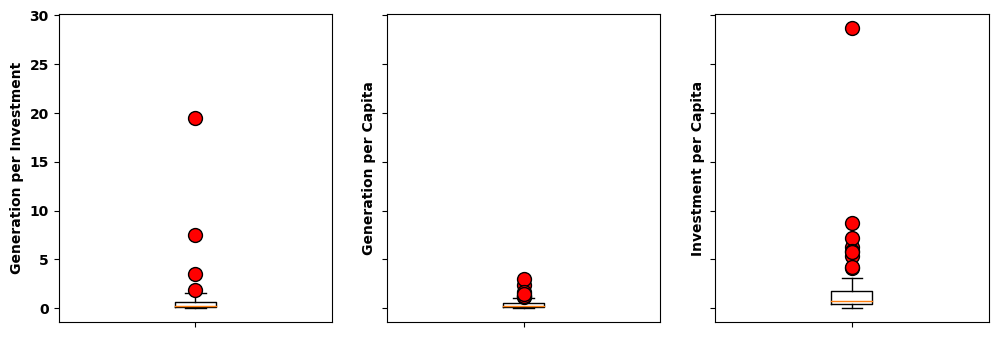

In [14]:
# Generate a box plot of the Total Generation per Investment
y_axis1 = final_state['Generation per Investment']
y_axis2 = final_state['Generation per Capita']

y_axis3 = final_state['Investment per Capita']

fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
ax[0].set_ylabel('Generation per Investment')
ax[0].boxplot(y_axis1, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[0].set_xticklabels('')

ax[1].set_ylabel('Generation per Capita')
ax[1].boxplot(y_axis2, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[1].set_xticklabels('')

ax[2].set_ylabel('Investment per Capita')
ax[2].boxplot(y_axis3, flierprops = {'marker': 'o', 'markersize': 10, 'markerfacecolor': 'red'})
ax[2].set_xticklabels('')

plt.show()